<a href="https://colab.research.google.com/github/PacoElizondo/ComputerVisionUPT/blob/main/Exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying noise

In [1]:
import skimage as sk

img_coffee = sk.data.coffee()
filtered_images = []

noises = (
    'gaussian',
    'localvar',
    'poisson',
    'salt',
    'pepper',
    's&p',
    'speckle'
)

for noise in noises:
  filtered_images.append(sk.util.random_noise(img_coffee, mode=noise))



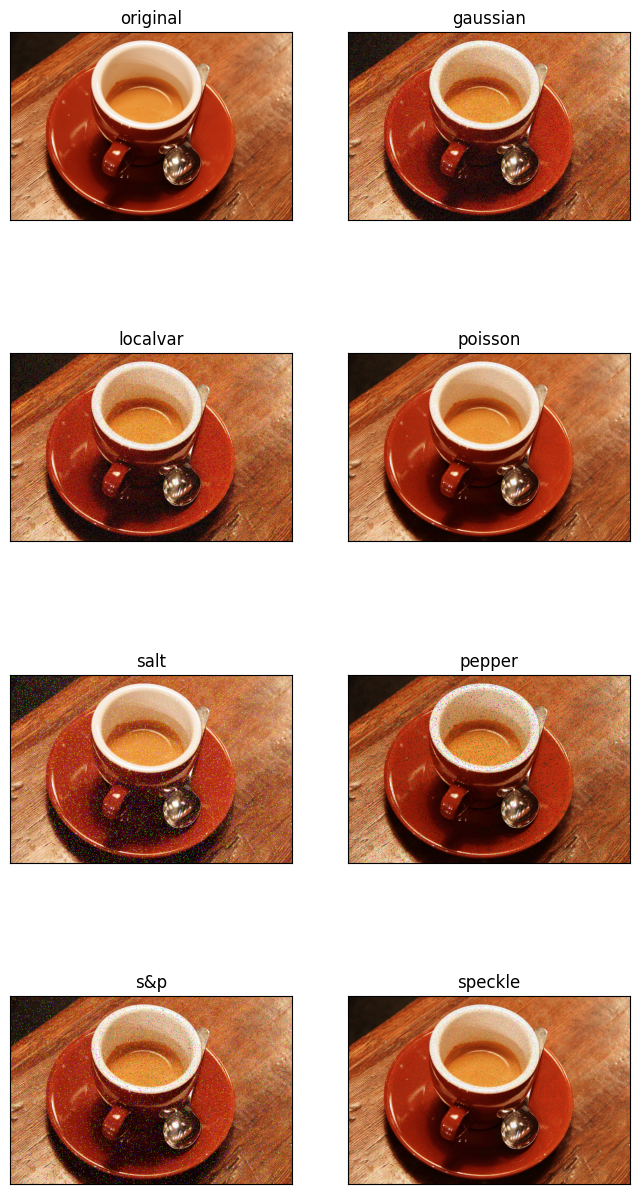

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 16))
i = 0
plt.subplot(4, 2, 1), plt.imshow(img_coffee)
plt.title('original'), plt.xticks([]), plt.yticks([])
for noise in noises:
  plt.subplot(4, 2, i+2), plt.imshow(filtered_images[i])
  plt.title(noise), plt.xticks([]), plt.yticks([])
  i += 1



# Speckle filter intensity

Speckle is a multiplicative noise:


`
out = val + n*val
`

where val is the current pixel value and n is a gaussian noise of specified mean.

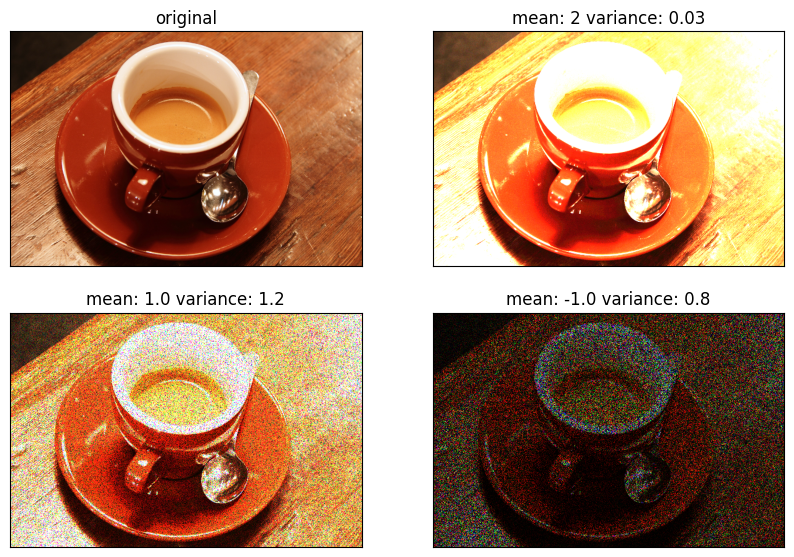

In [3]:
fig = plt.figure(figsize=(10, 14))
speckled_coffees = []
means = [2, 1.0, -1.0]
vars = [0.03, 1.2, 0.8]
plt.subplot(4, 2, 1), plt.imshow(img_coffee), plt.xticks([]), plt.yticks([])
plt.title('original')
for mv in range (0,3):
  speckled_coffees.append( sk.util.random_noise(img_coffee, mode='speckle', mean=means[mv], var=vars[mv]))
  plt.subplot(4, 2, mv+2), plt.imshow(speckled_coffees[mv])
  plt.xticks([]), plt.yticks([])
  plt.title('mean: ' + str(means[mv]) + ' variance: ' + str(vars[mv]))



It appears that the mean affects brightness while the variance the noise itself.

# Standard deviation effect on gaussian filter

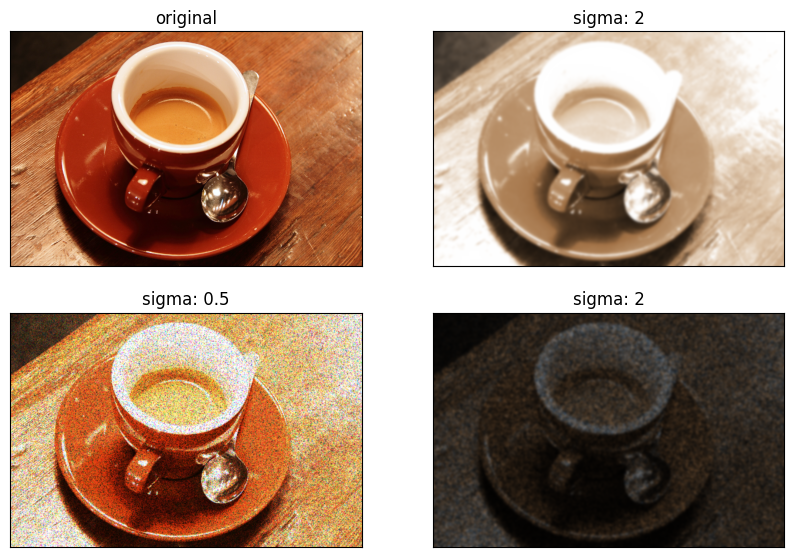

In [4]:
gaussian_speckled_coffees = []
fig = plt.figure(figsize=(10, 14))
plt.subplot(4, 2, 1), plt.imshow(img_coffee), plt.xticks([]), plt.yticks([])
plt.title('original')
stan_dev = [2, 0.5, 2]

for sv in range (0,3):
  gaussian_speckled_coffees.append(sk.filters.gaussian(speckled_coffees[sv], sigma=stan_dev[sv]))
  plt.subplot(4, 2, sv+2), plt.imshow(gaussian_speckled_coffees[sv])
  plt.xticks([]), plt.yticks([])
  plt.title('sigma: ' + str(stan_dev[sv]) )

High standard deviation on a gaussian blurs the image, because of this it loses contrast/flattens color.

# Edge detection

(<Axes: >, <matplotlib.image.AxesImage at 0x7a77a9503050>)

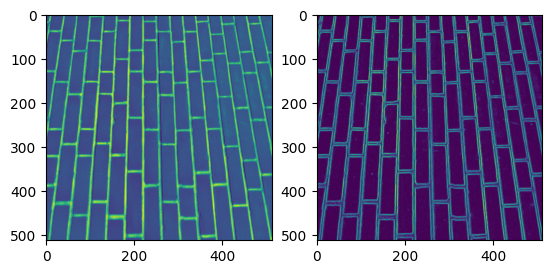

In [5]:
bricks = sk.data.brick()
prewitt_bricks = sk.filters.prewitt(bricks)
fig = plt.figure()
plt.subplot(1, 2, 1), plt.imshow(bricks)
plt.subplot(1, 2, 2), plt.imshow(prewitt_bricks)

In [21]:
import numpy as np

edge_threshold = sk.filters.threshold_otsu(prewitt_bricks)
edge_pixels = np.sum(prewitt_bricks > edge_threshold)
total_pixels = np.size(prewitt_bricks)
fraction = (edge_pixels / total_pixels) * 100

print(edge_pixels)
print(total_pixels)
print(str(round(fraction)) + '%')

55487
262144
21%


# Filter in the frequency domain

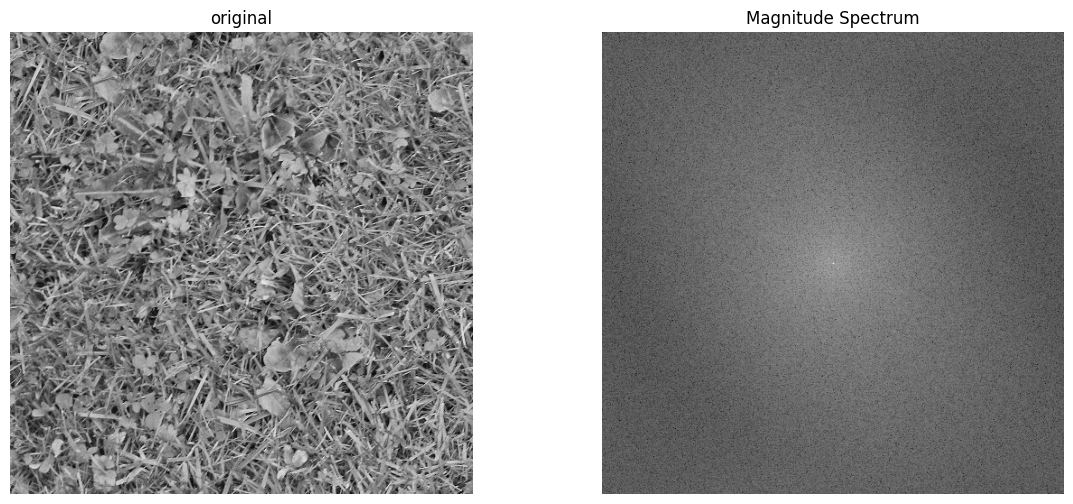

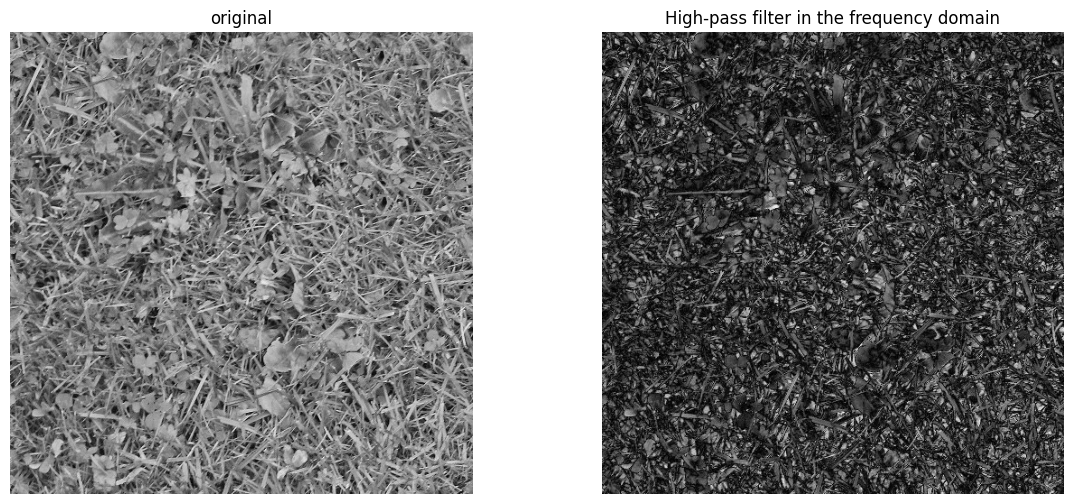

In [70]:
from skimage.color import rgb2gray

grass = sk.data.grass()

f = np.fft.fft2(grass)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))


def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

plot_comparison(grass, magnitude_spectrum, 'Magnitude Spectrum')

shift_value = 8

rows, cols = grass.shape
crow,ccol = int(rows/2) , int(cols/2)
fshift[crow-shift_value:crow+shift_value, ccol-shift_value:ccol+shift_value] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plot_comparison(grass,img_back, 'High-pass filter in the frequency domain')


The high-pass filter outputs a sharp image; it highlights the edges. In this case the threshold is low as the magnitude spectrum is relatively flat.

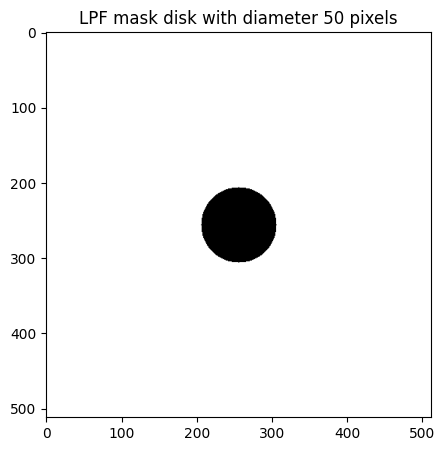

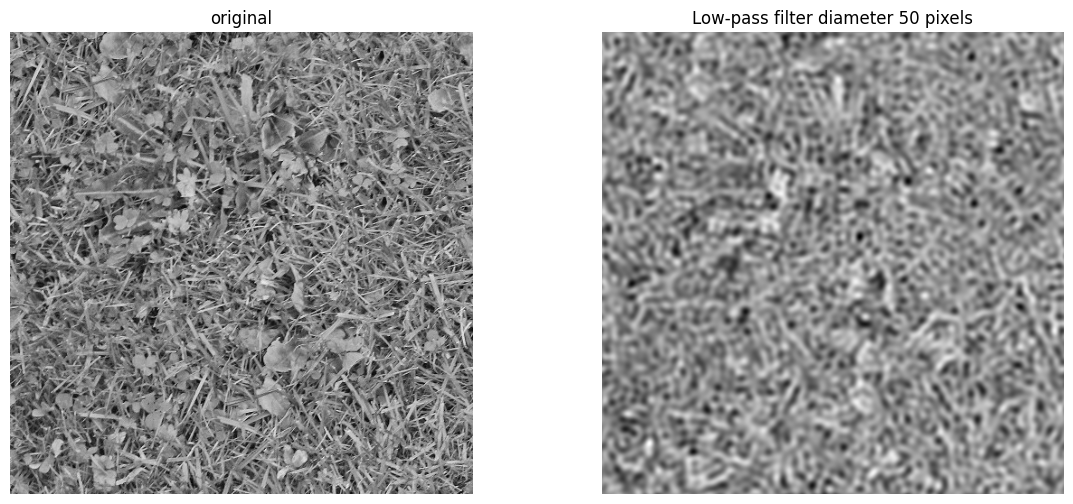

In [73]:
nrows, ncols = grass.shape
row, col = np.ogrid[:nrows, :ncols]
cnt_row, cnt_col = nrows / 2, ncols / 2
disk_diameter = 50
outer_disk_mask = ((row - cnt_row)**2 + (col - cnt_col)**2 > (disk_diameter)**2)

f = np.fft.fft2(grass)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

fshift[outer_disk_mask] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

fig = plt.figure(figsize=(5,5))
plt.imshow(outer_disk_mask,cmap=plt.cm.gray)
plt.title('LPF mask disk with diameter {} pixels'.format(disk_diameter))
plt.show()

plot_comparison(grass,img_back, 'Low-pass filter diameter {} pixels'.format(disk_diameter))

The lowpass filter excludes the values outside of the disk in the magnitude spectrum, where the center values represent the low frequencies. This affects the image in the opposite way as the high-pass filter; instead of making a sharper image, it makes it blurry, flattening all sharp features (edges).

# Blob Erosion

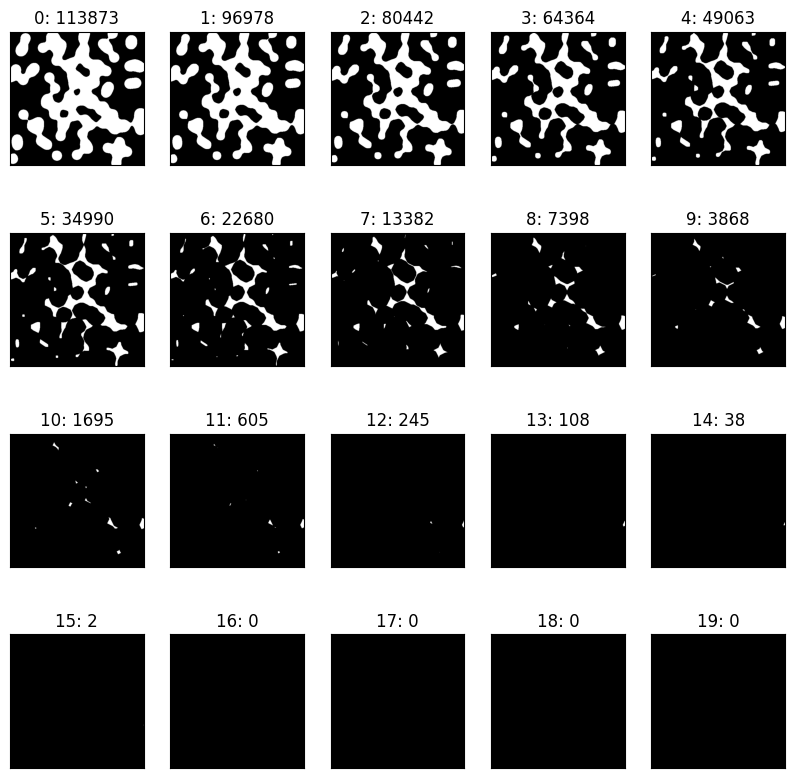

In [145]:
blob = sk.data.binary_blobs()

iterations = 20
rows = 4

fig = plt.figure(figsize=(10,10))

plt.subplot(4, 5, 1)
plt.xticks([]), plt.yticks([])
plt.title(0)
plt.imshow(blob, cmap='grey')
disk = sk.morphology.disk(3)

for i in range(0,iterations):
  erosioned_blob = sk.morphology.erosion(blob, disk)
  plt.subplot(4, 5, i+1)
  plt.xticks([]), plt.yticks([])
  plt.title(str(i) + ': ' + str(np.sum(erosioned_blob)))
  plt.imshow(erosioned_blob, cmap='gray')
  blob = erosioned_blob



It depends on the original random blob, thus the total values (of white pixels) are shown above the plot. Normally between 10 and 20.